# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from PIL import Image, ImageDraw, ImageFont

In [2]:
dataset = get_dataset("/data/waymo/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/data/waymo/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/data/waymo/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 103
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


In [23]:
dataset

<DatasetV1Adapter shapes: {image: (None, None, 3), source_id: (), key: (), filename: (), groundtruth_image_confidences: (None,), groundtruth_verified_neg_classes: (None,), groundtruth_not_exhaustive_classes: (None,), groundtruth_boxes: (None, 4), groundtruth_area: (None,), groundtruth_is_crowd: (None,), groundtruth_difficult: (None,), groundtruth_group_of: (None,), groundtruth_weights: (None,), groundtruth_classes: (None,), groundtruth_image_classes: (None,), original_image_spatial_shape: (2,)}, types: {image: tf.uint8, source_id: tf.string, key: tf.string, filename: tf.string, groundtruth_image_confidences: tf.float32, groundtruth_verified_neg_classes: tf.int64, groundtruth_not_exhaustive_classes: tf.int64, groundtruth_boxes: tf.float32, groundtruth_area: tf.float32, groundtruth_is_crowd: tf.bool, groundtruth_difficult: tf.int64, groundtruth_group_of: tf.bool, groundtruth_weights: tf.float32, groundtruth_classes: tf.int64, groundtruth_image_classes: tf.int64, original_image_spatial_sh

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [40]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    # ADD CODE HERE
    %matplotlib notebook
    fig, axs = plt.subplots(3,4, figsize = (10,10))
    column = 1
    row = 1
    for data in batch:
        image = data['image'].numpy()
        gt_bbox = data['groundtruth_boxes'].numpy()
        gt_classes = data['groundtruth_classes'].numpy()
        file = data['filename']

        w,h,_ = image.shape

        w_factor = w/1920
        h_factor = h/1280

        gt_bbox_scaled = gt_bbox.copy()
        gt_bbox_scaled[:,[0,2]] = gt_bbox[:,[0,2]] * h_factor * h
        gt_bbox_scaled[:,[1,3]] = gt_bbox[:,[1,3]] * w_factor * w

        colors = ['r', 'b', 'g', 'k', 'c']

        axs[row-1, column-1].imshow(image)

        for cl, bbox in zip(gt_classes, gt_bbox_scaled):
            y1,x1,y2,x2 = bbox
            #print (file +', (' + str(x1) + ',' + str(y1) + '), ' 
            #       + str(x2-x1) + ', ' 
            #       + str(y2-y1) 
            #       + ', class = ' + str(cl))
            rect = Patches.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor = colors[cl], facecolor = 'None')
            axs[row-1, column-1].add_patch(rect)

        if column % 4 == 0:
         #   print('Reset column')
            row += 1
            column = 1
        else:
          #  print('Increase column')
            column += 1
    plt.tight_layout()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

<IPython.core.display.Javascript object>


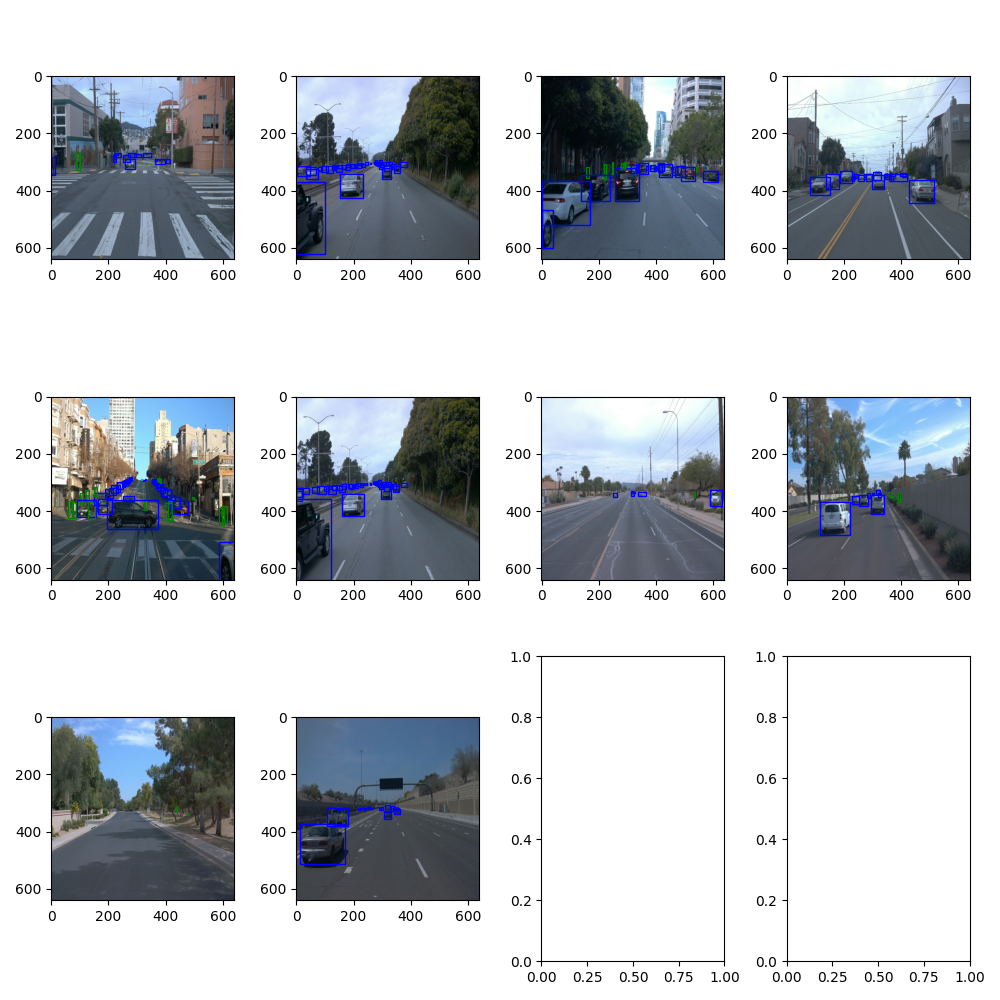

In [7]:
## STUDENT SOLUTION HERE
dataset = dataset.shuffle(100)
display_instances(dataset.take(10))

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [15]:
import seaborn as sns
import pandas as pd
from PIL import ImageStat
import numpy as np

files = []
bright = []
vehicles = []
pedestrians = []
cyclists = []
signs = []

def get_perceived_brightness(image):
    # convert image to PIL object to calculate the perceived brightness using the formula 
    # (0.21 x R) + (0.72 x G) + (0.07 x B)
    # INPUT: we expect the input as a numpy array
    im = Image.fromarray(np.uint8(image))
    stat = ImageStat.Stat(im)
    r,g,b = stat.mean
    return np.sqrt((0.21*(r**2) + 0.72*(g**2) + 0.07*(b**2)))

for data in dataset:
    image = data['image'].numpy()
    brightness = get_perceived_brightness(image) 
    gt_classes = data['groundtruth_classes'].numpy()
    file = data['filename']
    
    #print (file)
    veh = (gt_classes == 1).sum()
    ped = (gt_classes == 2).sum()
    cyc = (gt_classes == 3).sum()
    sig = (gt_classes == 4).sum()
    
    
    files.extend(file.numpy().decode('utf-8'))
    vehicles.extend([veh])
    pedestrians.extend([ped])
    cyclists.extend([cyc])
    signs.extend([sig])
    bright.extend([brightness])
    


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa8 in position 40: invalid start byte

In [16]:
len(pedestrians)

233

In [9]:
dict = {'Vehicles':vehicles, 'Pedestrians': pedestrians, 'Signs': signs, 'Cyclists': cyclists,
        'brightness': brightness}
df = pd.DataFrame(dict)

<IPython.core.display.Javascript object>


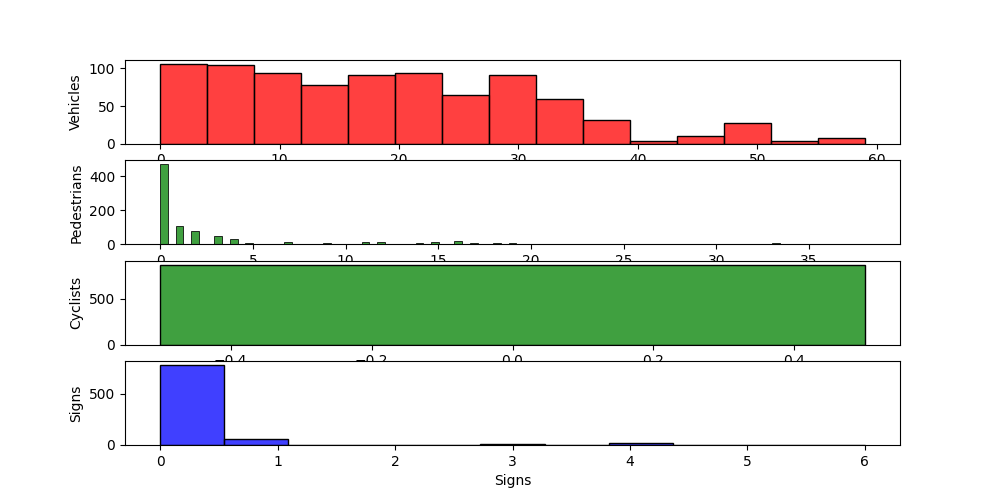

Text(0, 0.5, 'Signs')

In [19]:
%matplotlib notebook
fig, axs = plt.subplots(4,1, figsize = (10,5))
sns.histplot(df['Vehicles'], label = 'Vehicles', color = 'r', ax = axs[0])
axs[0].set_ylabel('Vehicles')
sns.histplot(df['Pedestrians'], label = 'Pedestrians', color = 'g', ax = axs[1])
axs[1].set_ylabel('Pedestrians')
sns.histplot(df['Cyclists'], label = 'Pedestrians', color = 'g', ax = axs[2])
axs[2].set_ylabel('Cyclists')
sns.histplot(df['Signs'], label = 'Signs', color = 'b', ax = axs[3])
axs[3].set_ylabel('Signs')

In [59]:
im = Image.fromarray(np.uint8(image))
stat = ImageStat.Stat(im)
r,g,b = stat.mean

In [63]:
veh = (gt_classes == 1).sum()
veh

49